In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

import pandas as pd
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

Populating the interactive namespace from numpy and matplotlib


In [ ]:
"""
1. get X and Y
2. Train and test
3. put data through linear regression
 - X fit
4. predict with test
5. get score R2 or MSE
6. Plot
   - scatter plot prediction vs actual

"""

In [ ]:
!ls data/

In [16]:
dfp1 = pd.read_json('data/1-3-bed-manhattan-pg332.json')


In [17]:
dfp2 = pd.read_json('data/1-3-bed-manhattan-pg332-601.json')


In [18]:
df_concat = pd.concat([dfp1, dfp1])

In [19]:
df_na = df_concat.dropna(subset=['street', 'price', 'neighborhood'])

In [20]:
df_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 4061
Data columns (total 12 columns):
price            8000 non-null int64
street           8000 non-null object
furnished        326 non-null object
url              8000 non-null object
beds             8000 non-null float64
baths            8000 non-null float64
no_broker_fee    8000 non-null float64
borough          8000 non-null object
city             8000 non-null object
sqft             2986 non-null object
neighborhood     8000 non-null object
address          8000 non-null object
dtypes: float64(3), int64(1), object(8)
memory usage: 812.5+ KB


In [22]:
def keep_int(element):
    if type(element) == int:
        return element
    else:
        return np.nan
      

In [23]:
df_na['sqft'] = df_na['sqft'].apply(keep_int)

/Users/greg/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
def remove_queries(element):
    if '?' in element:
        index = element.index('?')
        return element[:index]
    else:
        return element
        
    

In [70]:
df_na['url'] = df_na['url'].apply(remove_queries)

/Users/greg/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [88]:
df_sorted = df_na.sort_values(by=['sqft'])

In [61]:
def keep_furnished(element):
    if element == True:
        return True
    else:
        return False
      

False    8000
Name: url, dtype: int64

In [86]:
df_sorted['furnished'] = df_sorted.furnished.apply(keep_furnished)

In [236]:
sum(df_sorted.url.value_counts() > 2)

249

In [90]:
df_no_dup = df_sorted.drop_duplicates(['url'], keep="first")

In [92]:
df_no_dup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3751 entries, 1162 to 4061
Data columns (total 12 columns):
price            3751 non-null int64
street           3751 non-null object
furnished        154 non-null object
url              3751 non-null object
beds             3751 non-null float64
baths            3751 non-null float64
no_broker_fee    3751 non-null float64
borough          3751 non-null object
city             3751 non-null object
sqft             1384 non-null float64
neighborhood     3751 non-null object
address          3751 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 381.0+ KB


In [100]:
def clean_baths(val):
    if val >= 10:
        return val / 10
    return val

In [101]:
df_no_dup['baths'] = df_no_dup['baths'].apply(clean_baths)

/Users/greg/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [102]:
df = df_no_dup

,price,beds,baths,no_broker_fee,sqft
count,3751.000000,3751.000000,3751.000000,3751.000000,1384.000000
mean,4833.480405,1.652626,1.338443,0.569448,1041.004335
std,3589.752029,0.716356,0.577026,0.495219,519.521456
min,471.000000,1.000000,1.000000,0.000000,256.000000
25%,2950.000000,1.000000,1.000000,0.000000,700.000000
50%,3880.000000,2.000000,1.000000,1.000000,888.500000
75%,5400.000000,2.000000,2.000000,1.000000,1226.250000
max,70000.000000,3.000000,4.500000,1.000000,5000.000000


In [127]:
df_bed3 = df[(df.beds == 3) & (df.sqft > 0)]
df_bed2 = df[(df.beds == 2) & (df.sqft > 0)]
df_bed1 = df[(df.beds == 1) & (df.sqft > 0)]
df_sqft = df[df.sqft > 0]

In [10]:
def remove_outlier(df, col='price', threshold=1.5):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lowest_limit = df[col] >= q1 - (threshold * iqr)
    highest_limit = df[col] <= q3 + (threshold * iqr)
    return df[lowest_limit & highest_limit]    


In [3]:
pickle_filename = 'data/clean_1-3-bed-manhattan.pkl'
pickle_bed1 = 'data/clean_1-bed-manhattan.pkl'
pickle_bed2 = 'data/clean_2-bed-manhattan.pkl'
pickle_bed3 = 'data/clean_3-bed-manhattan.pkl'
pickle_sqft = 'data/clean-sqft-manhattan.pkl'



In [166]:
df.to_pickle(pickle_filename)
df_bed1.to_pickle(pickle_bed1)
df_bed2.to_pickle(pickle_bed2)
df_bed3.to_pickle(pickle_bed3)
df_sqft.to_pickle(pickle_sqft)

In [4]:
df = pd.read_pickle(pickle_filename)
dfb1 = pd.read_pickle(pickle_bed1)
dfb2 = pd.read_pickle(pickle_bed2)
dfb3 = pd.read_pickle(pickle_bed3)
dfs = pd.read_pickle(pickle_sqft)

In [27]:
def split_columns_val(df, y_col, x_cols, dummy_cols, remove_all_outliers = True):
    
    df = remove_outlier(df, y_col) if remove_all_outliers else df 
    
    dummy_df = pd.get_dummies(df, columns=dummy_cols, drop_first=True)
    
    agg_dummy_col_names = []
    
    for col_name in dummy_cols:
        dummy_col_names = [col for col in dummy_df.columns if col_name + '_' in col]
        agg_dummy_col_names += dummy_col_names
    
    cols = x_cols + agg_dummy_col_names
    
    return split_and_validate(dummy_df[cols], df[y_col])

In [6]:
def split_and_validate(X, y):

    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)

    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)

    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')
    
    return (X_train, X_val, y_train, y_val, lr_model)
        

In [7]:
df.head(1)

,price,street,furnished,url,beds,baths,no_broker_fee,borough,city,sqft,neighborhood,address
1162,3000,24 Jane Street #1B,None,https://streeteasy.com/building/24-jane-street...,1.0,1.0,1.0,manhattan,ny,256.0,West Village,"24 Jane Street #1B, West Village, ny"


In [21]:
df_X_cols = ['beds', 'baths']
dfs_X_cols = ['beds', 'baths', 'sqft'] # furnished has None values
dfb1_X_cols = ['baths']
dfb2_X_cols = ['baths']
dfb3_X_cols = ['baths']
dummies = ['neighborhood']

In [20]:
dfb1

,price,street,furnished,url,beds,baths,no_broker_fee,borough,city,sqft,neighborhood,address
1162,3000,24 Jane Street #1B,None,https://streeteasy.com/building/24-jane-street...,1.0,1.0,1.0,manhattan,ny,256.0,West Village,"24 Jane Street #1B, West Village, ny"
1973,2500,432 E 66th Street #14,None,https://streeteasy.com/building/432-east-66-st...,1.0,1.0,1.0,manhattan,ny,350.0,Lenox Hill,"432 E 66th Street #14, Lenox Hill, ny"
1974,2800,432 East 66th Street #7,None,https://streeteasy.com/building/432-east-66-st...,1.0,1.0,1.0,manhattan,ny,355.0,Lenox Hill,"432 East 66th Street #7, Lenox Hill, ny"
47,2199,101 Allen Street #4B,None,https://streeteasy.com/building/101-allen-stre...,1.0,1.0,0.0,manhattan,ny,400.0,Lower East Side,"101 Allen Street #4B, Lower East Side, ny"
2461,3248,63 W 104th Street #604,None,https://streeteasy.com/building/63-west-104-st...,1.0,1.0,1.0,manhattan,ny,419.0,Manhattan Valley,"63 W 104th Street #604, Manhattan Valley, ny"
...,...,...,...,...,...,...,...,...,...,...,...,...
2608,10000,81 White Street #5W,None,https://streeteasy.com/building/79_81-white-st...,1.0,1.5,0.0,manhattan,ny,1913.0,Tribeca,"81 White Street #5W, Tribeca, ny"
2947,8500,15 Broad Street #1614,True,https://streeteasy.com/building/downtown-by-ph...,1.0,2.0,0.0,manhattan,ny,2028.0,Financial District,"15 Broad Street #1614, Financial District, ny"
2369,16000,6 Bond Street #4,None,https://streeteasy.com/building/6-bond-street-...,1.0,1.5,0.0,manhattan,ny,2263.0,Noho,"6 Bond Street #4, Noho, ny"
333,10995,136 West Broadway #PH,None,https://streeteasy.com/building/136-west-broad...,1.0,2.0,1.0,manhattan,ny,2284.0,Tribeca,"136 West Broadway #PH, Tribeca, ny"


In [ ]:
"""
    make a pipeline
    
    consider kitchen sink approach
    
    i am feeding different bedrooms, it's basically a dummy variabe
    
"""

In [28]:
X_train, X_val, y_train, y_val, lr_model = split_columns_val(dfb1, 'price', dfb1_X_cols, dummies)


Validation R^2 score was: 0.3786952022992188
Feature coefficient results: 

baths : 1315.69
neighborhood_Beekman : -544.61
neighborhood_Carnegie Hill : 196.67
neighborhood_Central Harlem : -1944.71
neighborhood_Central Park South : 1149.21
neighborhood_Chelsea : 643.78
neighborhood_East Harlem : -1797.40
neighborhood_East Village : 427.15
neighborhood_Financial District : -74.53
neighborhood_Flatiron : 1157.67
neighborhood_Fort George : -2228.33
neighborhood_Fulton/Seaport : -427.00
neighborhood_Gramercy Park : 204.17
neighborhood_Greenwich Village : 129.53
neighborhood_Hamilton Heights : -1408.33
neighborhood_Hell's Kitchen : 54.70
neighborhood_Hudson Heights : -1813.33
neighborhood_Hudson Yards : 590.00
neighborhood_Inwood : -2328.33
neighborhood_Kips Bay : -439.29
neighborhood_Lenox Hill : -320.24
neighborhood_Lincoln Square : 359.38
neighborhood_Lower East Side : -671.00
neighborhood_Manhattan Valley : -1118.83
neighborhood_Midtown : 55.36
neighborhood_Midtown South : 156.01
neigh

In [24]:
X_train

,baths,baths,neighborhood_Battery Park City,neighborhood_Beekman,neighborhood_Carnegie Hill,neighborhood_Central Harlem,neighborhood_Central Park South,neighborhood_Chelsea,neighborhood_East Harlem,neighborhood_East Village,...,neighborhood_Sutton Place,neighborhood_Tribeca,neighborhood_Turtle Bay,neighborhood_Two Bridges,neighborhood_Upper East Side,neighborhood_Upper West Side,neighborhood_Washington Heights,neighborhood_West Chelsea,neighborhood_West Village,neighborhood_Yorkville
3695,1.5,1.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3121,1.0,1.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2249,1.0,1.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3337,1.5,1.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1077,1.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4017,1.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3356,1.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1546,1.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1759,1.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
y_hat = lr_model.predict(X_val)

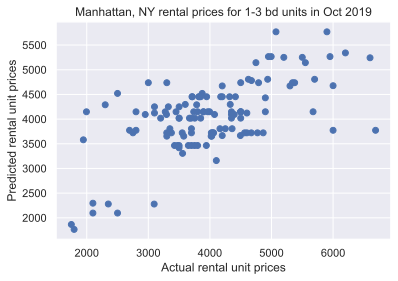

In [32]:
plt.scatter(y_val, y_hat)
plt.xlabel('Actual rental unit prices')
plt.ylabel('Predicted rental unit prices')
plt.title('Manhattan, NY rental prices for 1-3 bd units in Oct 2019')
plt.savefig('actual_rent_vs_predicted-svg.svg')
    

In [204]:
print('training score: ', lr_model.score(X_train, y_train))
print('testing score: ', lr_model.score(X_val, y_val))

training score:  0.7350549070811963
testing score:  0.732815175323842
